In [ ]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# ✅ API Key
api_key = "-"

# ✅ 재시도 가능한 세션 구성
session = requests.Session()
retries = Retry(total=3, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount("http://", HTTPAdapter(max_retries=retries))

# ✅ Spot 정보 수집
spot_url = f"http://openapi.seoul.go.kr:8088/{api_key}/xml/SpotInfo/1/1000/"
res = session.get(spot_url, timeout=10)
root = ET.fromstring(res.content)

spot_list = []
for row in root.findall("row"):
    spot_list.append({
        "spot_num": row.find("spot_num").text,
        "spot_name": row.find("spot_nm").text,
        "x": float(row.find("grs80tm_x").text),
        "y": float(row.find("grs80tm_y").text),
    })

spot_df = pd.DataFrame(spot_list)

# ✅ 4월 주말 날짜 리스트
def get_weekends(year, month):
    weekends = []
    date = datetime(year, month, 1)
    while date.month == month:
        if date.weekday() >= 5:  # 토요일(5), 일요일(6)
            weekends.append(date.strftime("%Y%m%d"))
        date += timedelta(days=1)
    return weekends

dates = get_weekends(2025, 4)
hours = [f"{i:02d}" for i in range(24)]

# ✅ 교통량 수집
vol_records = []
fail_logs = []

for date in dates:
    for hour in hours:
        for spot in spot_df["spot_num"]:
            url = f"http://openapi.seoul.go.kr:8088/{api_key}/xml/VolInfo/1/100/{spot}/{date}/{hour}/"
            try:
                r = session.get(url, timeout=10)
                root = ET.fromstring(r.content)

                for row in root.findall("row"):
                    vol_records.append({
                        "spot_num": row.find("spot_num").text,
                        "date": row.find("ymd").text,
                        "hour": row.find("hh").text,
                        "inout": row.find("io_type").text,
                        "lane": row.find("lane_num").text,
                        "volume": int(row.find("vol").text)
                    })
            except Exception as e:
                print(f"❌ 요청 실패: {date} {hour} {spot} - {e}")
                fail_logs.append((date, hour, spot))

# ✅ 결과 정리
vol_df = pd.DataFrame(vol_records)
print(f"✅ 수집 완료: {len(vol_df)}건")
if fail_logs:
    print(f"⚠️ 실패 요청 수: {len(fail_logs)}")
    pd.DataFrame(fail_logs, columns=["date", "hour", "spot"]).to_csv("주말_요청실패.csv", index=False)

vol_df.to_csv("4_weekend.csv", index=False, encoding="utf-8-sig")


✅ 수집 완료: 161027건


In [ ]:
import pandas as pd

vol_df= pd.read_csv("4_weekend.csv")
vol_df

,spot_num,date,hour,inout,lane,volume
0,A-01,20250405,0,1,1,188
1,A-01,20250405,0,1,2,308
2,A-01,20250405,0,2,1,396
3,A-01,20250405,0,2,2,271
4,A-02,20250405,0,1,1,165
...,...,...,...,...,...,...
161022,F-09,20250427,23,2,2,121
161023,F-10,20250427,23,1,1,182
161024,F-10,20250427,23,1,2,173
161025,F-10,20250427,23,2,1,293


In [10]:

spot_df= pd.read_csv("spot_with_address.csv")
spot_df

,spot_num,spot_name,x,y,lon,lat,구,동,지역
0,A-01,성산로(금화터널),195489.000000,452136.000000,126.946835,37.571502,서대문구,봉원동,북서부
1,A-02,사직로(사직터널),196756.776106,452546.638644,126.961184,37.575207,종로구,무악동,북서부
2,A-03,자하문로(자하문터널),197216.855046,454350.990432,126.966385,37.591465,종로구,청운동,북서부
3,A-04,대사관로(삼청터널),198648.893154,455200.108465,126.982598,37.599119,성북구,성북동,북서부
4,A-05,율곡로(안국역),198645.671347,452937.216603,126.982566,37.578731,종로구,안국동,북서부
...,...,...,...,...,...,...,...,...,...
134,F-06,경부고속도로,202107.000000,443264.000000,127.021724,37.491575,서초구,서초동,남동부
135,F-07,분당수서로,207716.000000,444241.000000,127.085158,37.500348,송파구,삼전동,남동부
136,F-08,강남순환로(관악터널),191832.000000,437667.000000,126.905601,37.441111,금천구,시흥동,남서부
137,F-09,서부간선지하도로,189706.000000,441044.000000,126.881529,37.471517,금천구,가산동,남서부


In [59]:
import pandas as pd

# ✅ 병합
merged_df = pd.merge(vol_df, spot_df, on="spot_num", how="left")

# ✅ 필요한 열 선택 및 결측치 제거 (선제적 정리)
# merged_df = merged_df[["spot_num", "spot_name", "date", "hour", "inout", "volume", "구", "동", "지역"]]
# merged_df.dropna(subset=["지역", "volume"], inplace=True)

# ✅ 지역별 혼잡도 집계 (유입, 유출 따로)
region_gb = (
    merged_df.groupby(["date", "hour","구", "동", "지역",  "spot_name", "inout"])[["volume"]]
    .sum()
    .reset_index()
    .rename(columns={"volume": "총교통량"})
)

# ✅ 유입/유출 해석 이름 붙이기
region_gb["구분"] = region_gb["inout"].map({1: "유입", 2: "유출"})

# ✅ 시간대별 정렬
region_gb = region_gb.sort_values(by=["date", "hour", "지역"])

# ✅ 예시 저장
# region_gb.to_csv("지역별_시간별_교통량.csv", index=False, encoding="utf-8-sig")
# print("✅ 저장 완료: 지역별_시간별_교통량.csv")


In [15]:
region_gb

,date,hour,구,동,지역,spot_name,inout,총교통량,구분
0,20250405,0,강남구,삼성동,남동부,테헤란로(선릉역),1,942,유입
1,20250405,0,강남구,삼성동,남동부,테헤란로(선릉역),2,1013,유출
2,20250405,0,강남구,세곡동,남동부,밤고개로(세곡동사거리),1,177,유입
3,20250405,0,강남구,세곡동,남동부,밤고개로(세곡동사거리),2,155,유출
4,20250405,0,강남구,세곡동,남동부,헌릉로(세곡동사거리),1,330,유입
...,...,...,...,...,...,...,...,...,...
49479,20250427,23,중구,순화동,북서부,세종대로(서울역),2,655,유출
49480,20250427,23,중구,순화동,북서부,칠패로(숭례문),1,19,유입
49481,20250427,23,중구,순화동,북서부,칠패로(숭례문),2,480,유출
49488,20250427,23,중구,정동,북서부,서소문로(시청역),1,550,유입


In [ ]:
import pandas as pd

# 데이터 불러오기
df = region_gb
# 날짜형식 변환 및 요일 컬럼 추가
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday"] = df["date"].dt.day_name()

# 토요일, 일요일 필터링
weekend_df = df[df["weekday"].isin(["Saturday", "Sunday"])]


# 요일별 지역별 총교통량 집계
region_summary = weekend_df.groupby(["weekday", "지역"])["총교통량"].sum().reset_index()
region_summary = region_summary.sort_values(["weekday", "총교통량"], ascending=[True, False])

# 요약 결과 확인
print(region_summary)


    weekday   지역     총교통량
1  Saturday  남서부  9844193
0  Saturday  남동부  9402077
3  Saturday  북서부  7562835
2  Saturday  북동부  7203345
5    Sunday  남서부  8851271
4    Sunday  남동부  8382275
7    Sunday  북서부  7007752
6    Sunday  북동부  6625298


In [38]:
import pandas as pd

# 데이터 불러오기
df = region_gb

# 날짜형식 변환 및 요일 컬럼 추가 (영어로)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# 영어 -> 한글 요일 변환
day_map = {
    "Monday": "월요일",
    "Tuesday": "화요일",
    "Wednesday": "수요일",
    "Thursday": "목요일",
    "Friday": "금요일",
    "Saturday": "토요일",
    "Sunday": "일요일"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# 토요일, 일요일 필터링
weekend_df = df[df["weekday"].isin(["토요일", "일요일"])]

# 요일별 지역별 총교통량 집계
region_summary = weekend_df.groupby(["weekday", "지역"])["총교통량"].median().reset_index()
region_summary = region_summary.sort_values(["weekday", "총교통량"], ascending=[False, False])

# 요약 결과 확인
print(region_summary)


  weekday   지역    총교통량
4     토요일  남동부  1522.0
6     토요일  북동부  1184.5
5     토요일  남서부   915.5
7     토요일  북서부   861.0
0     일요일  남동부  1289.0
2     일요일  북동부  1016.0
3     일요일  북서부   794.0
1     일요일  남서부   772.0


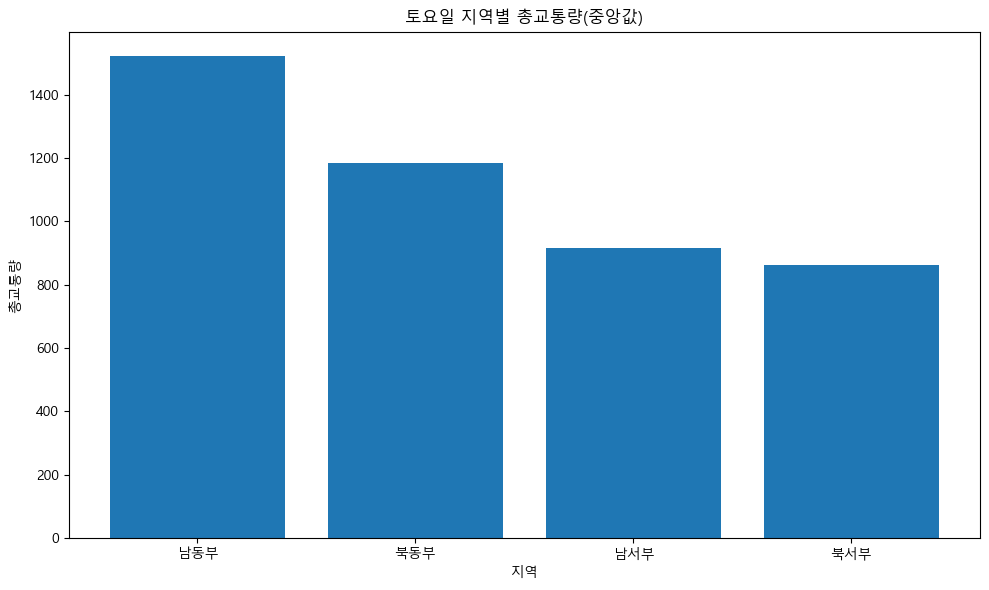

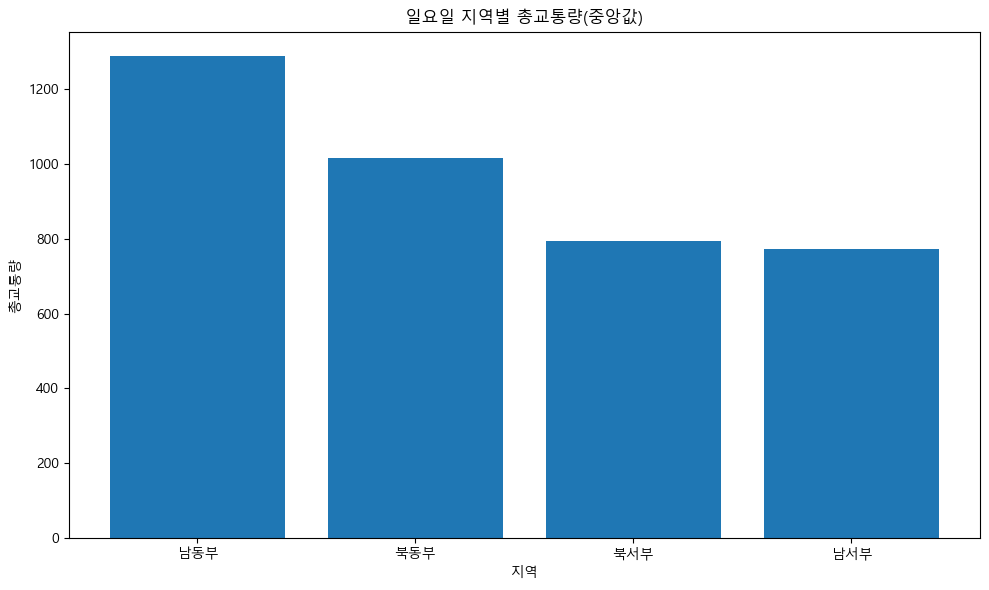

In [39]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# (한글 깨짐 방지 - 필요시 폰트 지정)
# fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')  # 리눅스 예시
plt.rc('font', family='Malgun Gothic')  # 윈도우는 보통 'Malgun Gothic'
plt.rc('axes', unicode_minus=False)     # 마이너스 깨짐 방지

# 요일별로 나눠서 그리기
weekdays = ["토요일", "일요일"]

for day in weekdays:
    day_data = region_summary[region_summary["weekday"] == day]
    plt.figure(figsize=(10, 6))
    plt.bar(day_data["지역"], day_data["총교통량"])
    plt.title(f"{day} 지역별 총교통량(중앙값)")
    plt.xlabel("지역")
    plt.ylabel("총교통량")
    # plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    지역      총교통량
1  남서부  18695464
0  남동부  17784352
3  북서부  14570587
2  북동부  13828643


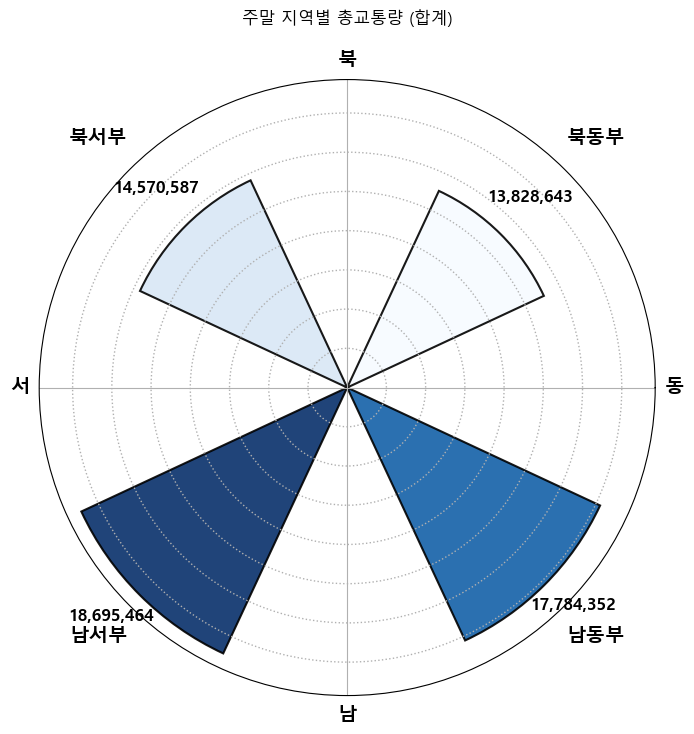

'\n🔍 왜 이런 결과가 나올까?\n✅ 중앙값(median)\n\n단순히 모든 값들을 크기순으로 나열했을 때 딱 중간 값.\n\n극단적으로 큰 값(이상치)이 있더라도 그 영향은 거의 없음.\n\n즉, 일상적인 "평범한" 흐름의 대표값을 보여줌.\n\n✅ 총합(sum)\n\n모든 값을 더한 값이기 때문에\n\n값이 높은 날이 몇 번만 나와도 전체 합계를 크게 만듦.\n\n즉, 특정 기간 동안 전체 규모(누적)를 보여줌.\n\n📊 그래서\n남동부\n→ 평상시 트래픽(중앙값)이 제일 높아서 “평균적으로 붐비는” 곳.\n\n남서부\n→ 며칠 교통량이 엄청 높아서 누적합이 더 커진 것일 가능성이 큼.\n(ex: 대형 행사, 공사 우회 등 특정 기간에 트래픽 급증)\n'

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd

# 데이터 불러오기
df = region_gb

# 날짜형식 변환 및 요일 컬럼 추가 (영어로)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# 영어 -> 한글 요일 변환
day_map = {
    "Monday": "월요일",
    "Tuesday": "화요일",
    "Wednesday": "수요일",
    "Thursday": "목요일",
    "Friday": "금요일",
    "Saturday": "토요일",
    "Sunday": "일요일"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# 토요일, 일요일 필터링
weekend_df = df[df["weekday"].isin(["토요일", "일요일"])]

# 요일별 지역별 총교통량 집계
region_summary = weekend_df.groupby(["지역"])["총교통량"].sum().reset_index()
region_summary = region_summary.sort_values([ "총교통량"], ascending=[ False])

# 요약 결과 확인
print(region_summary)

# 데이터 준비
data = region_summary
angle_map = {'남동부': 315, '북동부': 45, '북서부': 135, '남서부': 225}
angles = [np.deg2rad(angle_map[area]) for area in data['지역']]
traffic = data['총교통량']
norm_traffic = (traffic - min(traffic)) / (max(traffic) - min(traffic))

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

# 막대 그래프 그리기 (테두리 추가)
for angle, height, norm_val in zip(angles, traffic, norm_traffic):
    ax.bar(angle, height, width=np.deg2rad(40), 
           color=plt.cm.Blues(norm_val), 
           edgecolor='black', linewidth=1.5, 
           align='center', alpha=0.9)

# 동서남북 라벨
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['동', '북', '서', '남'], fontsize=14, fontweight='bold')

# 대각선 방위 라벨
for area, angle_deg in angle_map.items():
    angle_rad = np.deg2rad(angle_deg)
    r = max(traffic) * 1.2
    ax.text(angle_rad, r, area, ha='center', va='center', 
            fontsize=14, color='black', fontweight='bold')

# 막대 위에 값 표시
for angle, height in zip(angles, traffic):
    ax.text(angle, height + (max(traffic)*0.14), f'{height:,.0f}', 
            ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# 반지름 눈금 점선으로
ax.yaxis.grid(True, linestyle=':', linewidth=1)
ax.set_yticklabels([])

plt.title("주말 지역별 총교통량 (합계)", pad=20)
plt.show()
'''
🔍 왜 이런 결과가 나올까?
✅ 중앙값(median)

단순히 모든 값들을 크기순으로 나열했을 때 딱 중간 값.

극단적으로 큰 값(이상치)이 있더라도 그 영향은 거의 없음.

즉, 일상적인 "평범한" 흐름의 대표값을 보여줌.

✅ 총합(sum)

모든 값을 더한 값이기 때문에

값이 높은 날이 몇 번만 나와도 전체 합계를 크게 만듦.

즉, 특정 기간 동안 전체 규모(누적)를 보여줌.

📊 그래서
남동부
→ 평상시 트래픽(중앙값)이 제일 높아서 “평균적으로 붐비는” 곳.

남서부
→ 며칠 교통량이 엄청 높아서 누적합이 더 커진 것일 가능성이 큼.
(ex: 대형 행사, 공사 우회 등 특정 기간에 트래픽 급증)
'''

    지역    총교통량
0  남동부  1409.0
2  북동부  1103.0
1  남서부   845.0
3  북서부   826.5


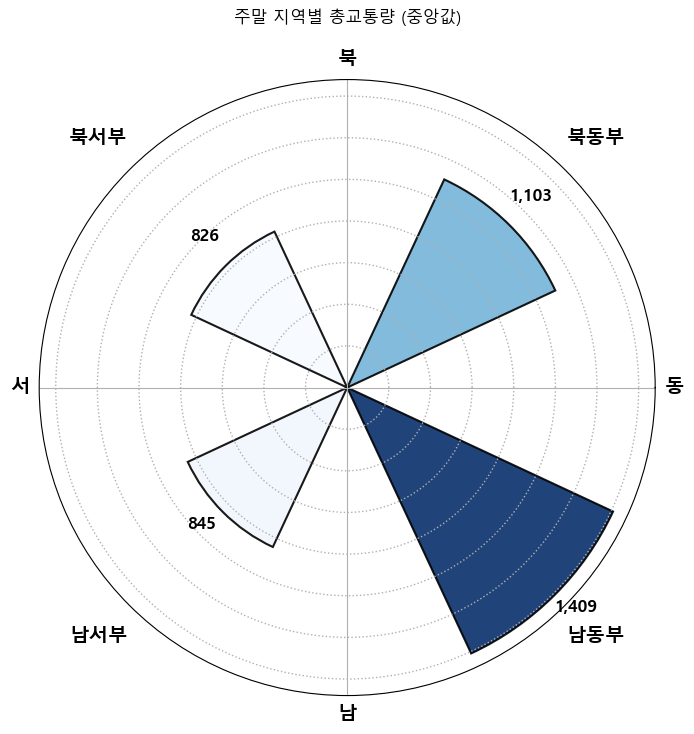

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd

# 데이터 불러오기
df = region_gb

# 날짜형식 변환 및 요일 컬럼 추가 (영어로)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# 영어 -> 한글 요일 변환
day_map = {
    "Monday": "월요일",
    "Tuesday": "화요일",
    "Wednesday": "수요일",
    "Thursday": "목요일",
    "Friday": "금요일",
    "Saturday": "토요일",
    "Sunday": "일요일"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# 토요일, 일요일 필터링
weekend_df = df[df["weekday"].isin(["토요일", "일요일"])]

# 요일별 지역별 총교통량 집계
region_summary = weekend_df.groupby(["지역"])["총교통량"].median().reset_index()
region_summary = region_summary.sort_values([ "총교통량"], ascending=[ False])

# 요약 결과 확인
print(region_summary)

# 데이터 준비
data = region_summary
angle_map = {'남동부': 315, '북동부': 45, '북서부': 135, '남서부': 225}
angles = [np.deg2rad(angle_map[area]) for area in data['지역']]
traffic = data['총교통량']
norm_traffic = (traffic - min(traffic)) / (max(traffic) - min(traffic))

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

# 막대 그래프 그리기 (테두리 추가)
for angle, height, norm_val in zip(angles, traffic, norm_traffic):
    ax.bar(angle, height, width=np.deg2rad(40), 
           color=plt.cm.Blues(norm_val), 
           edgecolor='black', linewidth=1.5, 
           align='center', alpha=0.9)

# 동서남북 라벨
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['동', '북', '서', '남'], fontsize=14, fontweight='bold')

# 대각선 방위 라벨
for area, angle_deg in angle_map.items():
    angle_rad = np.deg2rad(angle_deg)
    r = max(traffic) * 1.2
    ax.text(angle_rad, r, area, ha='center', va='center', 
            fontsize=14, color='black', fontweight='bold')

# 막대 위에 값 표시
for angle, height in zip(angles, traffic):
    ax.text(angle, height + (max(traffic)*0.1), f'{height:,.0f}', 
            ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# 반지름 눈금 점선으로
ax.yaxis.grid(True, linestyle=':', linewidth=1)
ax.set_yticklabels([])

plt.title("주말 지역별 총교통량 (중앙값)", pad=20)
plt.show()

In [ ]:
import pandas as pd

# 데이터 불러오기
df = region_gb

# 날짜형식 변환 및 요일 컬럼 추가 (영어로)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# 영어 -> 한글 요일 변환
day_map = {
    "Monday": "월요일",
    "Tuesday": "화요일",
    "Wednesday": "수요일",
    "Thursday": "목요일",
    "Friday": "금요일",
    "Saturday": "토요일",
    "Sunday": "일요일"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# 토요일, 일요일 필터링
weekend_df = df[df["weekday"].isin(["토요일", "일요일"])]

# 요일별 지역별 총교통량 집계
region_summary = weekend_df.groupby(["weekday", "지역",'구'])["총교통량"].median().reset_index()
region_summary = region_summary.sort_values(["weekday", "총교통량"], ascending=[False, False])

# 요약 결과 확인
print(region_summary)


   weekday   지역    구    총교통량
65     토요일  북동부  구리시  3767.0
44     토요일  남동부  과천시  3174.5
57     토요일  남서부  마포구  2603.0
49     토요일  남동부  용산구  2374.0
78     토요일  북서부  마포구  2341.0
..     ...  ...  ...     ...
41     일요일  북서부   중구   369.0
17     일요일  남서부  서초구   365.0
22     일요일  북동부  광진구   351.0
1      일요일  남동부  강동구   330.0
11     일요일  남서부  광명시    64.0

[84 rows x 4 columns]


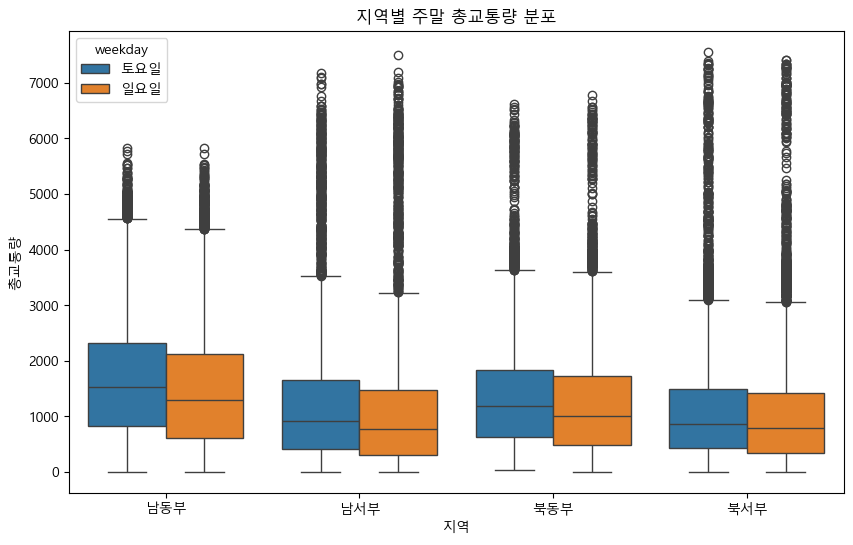

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(x='지역', y='총교통량', hue='weekday', data=df)
plt.title("지역별 주말 총교통량 분포")
plt.ylabel("총교통량")
plt.show()
'''
🔍 왜 박스플롯에 이상치가 그렇게 많이 찍히는가?
1️⃣ 데이터가 원래 극단적으로 치우쳐 있어서
교통량 데이터는 흔히 long-tail (우측으로 긴 꼬리) 분포를 가짐.

대부분 지점은 평소에 비교적 낮은 교통량

일부 지점만 특정 시간대에 엄청나게 몰림 (ex. 큰 도로, 입구, 터널, IC)

그래서 Q3 + 1.5 * IQR을 넘는 값이 다 이상치로 잡힘.
🚗 교통 데이터라서 특히 심함

교통 데이터는 평소엔 낮다가 특정 시간, 특정 구간에 확 몰림.

예: 월~금 출근시간, 토/일 대형 쇼핑몰 근처 → 몇만대 몰려서 극단적 트래픽 발생.

자연스럽게 박스플롯에서는 다 동그라미로 표시됨.

💡 그래서 어떻게 보나?
이상치를 숨기는 boxplot (showfliers=False) 으로 중위값과 IQR만 보고,

따로 히스토그램 / 커널밀도 (sns.kdeplot) 으로 전체 분포를 봐서 확인,

혹은 로그스케일로 줄여서 오른쪽 긴 꼬리까지 한눈에 보게 함.

'''

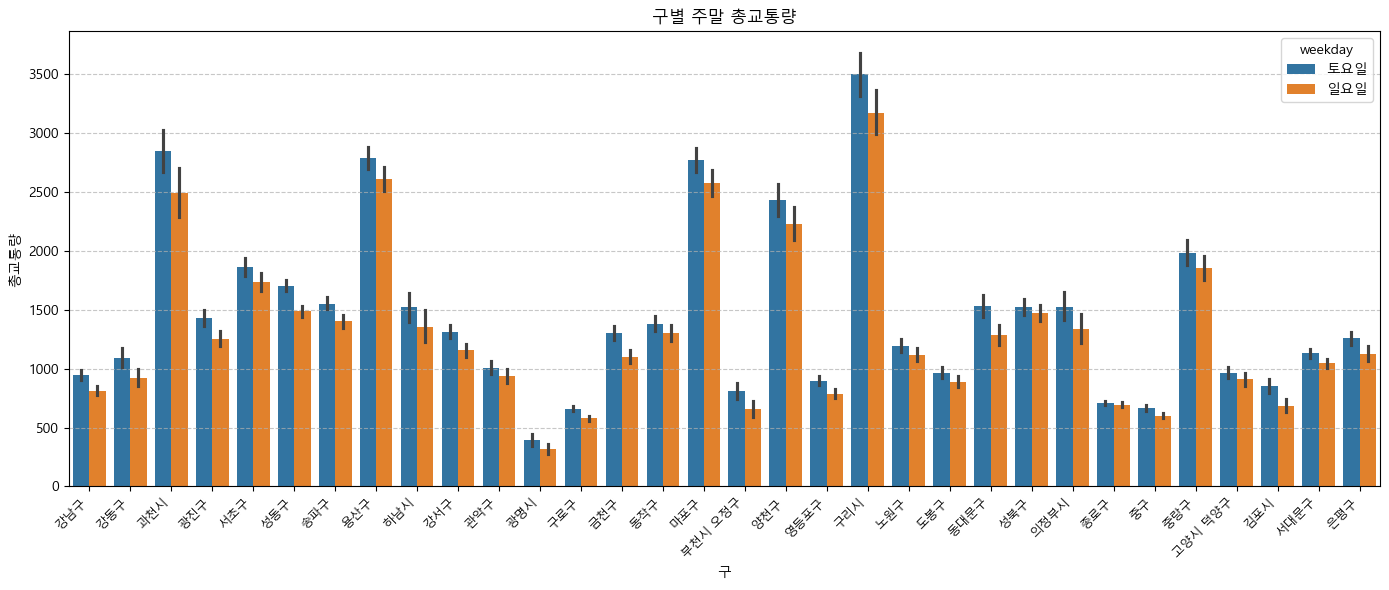

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
ax = sns.barplot(x='구', y='총교통량', hue='weekday', data=df)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.title("구별 주말 총교통량")
plt.tight_layout()

# y축 실선 (가로 그리드)
plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.7)

plt.show()
'''
✅ 서울 교통량 API (SpotInfo)
SpotInfo 는 서울시 교통량 측정소 데이터인데

서울 교통량은 서울시청 관할 측정소만 있는 게 아니야.

서울에 유입·유출되는 교통을 파악하기 위해
서울 주변(인접 경기도) 도로에도 측정소를 설치함.

그래서 부천, 고양, 광명 등이 나옴.
(서울 진입 관문인 김포, 고양 쪽에 측정소 많이 있음.)

즉 행정구역상 경기도라도, 서울 유입량을 측정하기 위해 설치된 측정소라서
서울 교통량 통계에 같이 포함됨.


🔍 과천시의 특이점
과천시는 작은 도시라서 행정구역상 '구'가 없음.

구 단위는 인구가 많고 면적이 큰 광역시나 특별시(서울, 부산, 대구…)에만 존재.

과천시 같은 **경기도 기초자치단체(시)**는 구 없이 바로 동으로 구성됨.

🔍 김포시도 왜 구가 없을까?
김포시는 경기도 기초자치단체(시) 라서 구가 없음.

즉 과천시, 부천시, 고양시, 김포시, 광명시, 의정부시... 모두 동일.

이런 도내 일반 시들은 행정구역이 시 → 동 구조지
시 → 구 → 동 구조가 아님.

'''

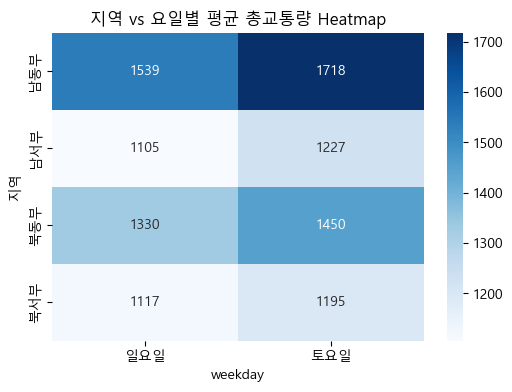

In [78]:
pivot = df.pivot_table(index='지역', columns='weekday', values='총교통량', aggfunc='mean')

plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Blues")
plt.title("지역 vs 요일별 평균 총교통량 Heatmap")
plt.show()


In [127]:
import pandas as pd

# 데이터 불러오기
df = region_gb

# 날짜형식 변환 및 요일 컬럼 추가 (영어로)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# 영어 -> 한글 요일 변환
day_map = {
    "Monday": "월요일",
    "Tuesday": "화요일",
    "Wednesday": "수요일",
    "Thursday": "목요일",
    "Friday": "금요일",
    "Saturday": "토요일",
    "Sunday": "일요일"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# 토요일, 일요일 필터링
weekend_df = df[df["weekday"].isin(["토요일", "일요일"])]

# 요일별 지역별 총교통량 집계
region_summary = weekend_df.groupby(["weekday", '구'])["총교통량"].median().reset_index()
region_summary = region_summary.sort_values(["weekday", "총교통량"], ascending=[False, False])

# 요약 결과 확인
print(region_summary)


   weekday        구    총교통량
41     토요일      구리시  3767.0
36     토요일      과천시  3174.5
48     토요일      마포구  2369.5
57     토요일      용산구  2259.5
62     토요일      중랑구  2049.0
..     ...      ...     ...
17     일요일  부천시 오정구   555.5
24     일요일     영등포구   551.0
29     일요일       중구   536.5
8      일요일      구로구   474.0
6      일요일      광명시    64.0

[64 rows x 3 columns]


In [128]:
import pandas as pd

# 데이터 불러오기
df = region_gb

# 날짜형식 변환 및 요일 컬럼 추가 (영어로)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# 영어 -> 한글 요일 변환
day_map = {
    "Monday": "월요일",
    "Tuesday": "화요일",
    "Wednesday": "수요일",
    "Thursday": "목요일",
    "Friday": "금요일",
    "Saturday": "토요일",
    "Sunday": "일요일"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# 토요일, 일요일 필터링
weekend_df = df[df["weekday"].isin(["토요일", "일요일"])]

# 요일별 지역별 총교통량 집계
region_summary = weekend_df.groupby(["weekday", '구','동'])["총교통량"].sum().reset_index()
region_summary = region_summary.sort_values(["weekday", "총교통량"], ascending=[False, False])

# 요약 결과 확인
print(region_summary.head(10))


    weekday     구     동     총교통량
161     토요일   용산구   이촌동  2359041
132     토요일   마포구   상암동  2191630
158     토요일  영등포구  여의도동  1143602
99      토요일   강서구   개화동   982728
145     토요일   성동구   옥수동   967434
140     토요일   서초구   서초동   948708
155     토요일   양천구   신월동   934305
152     토요일   송파구   삼전동   845740
120     토요일   구리시   토평동   818769
113     토요일   광진구   자양동   776104


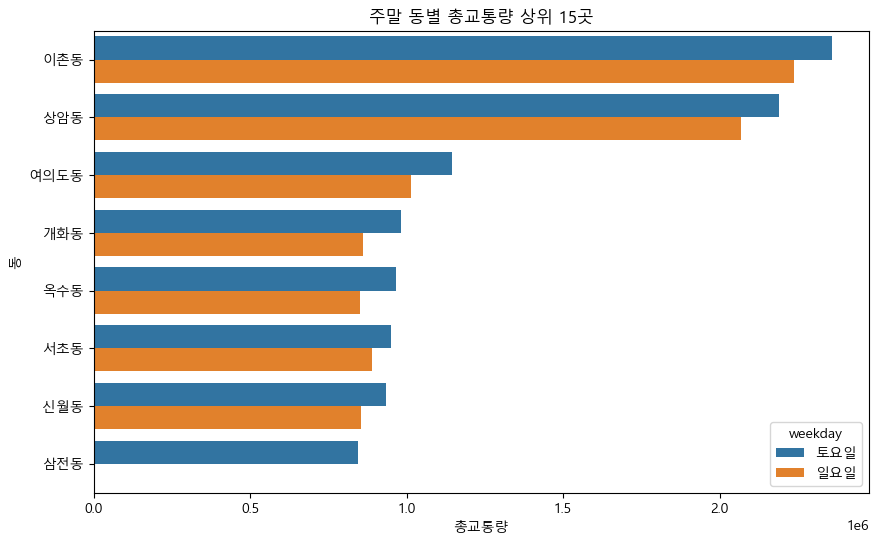

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

top_dong = region_summary.sort_values("총교통량", ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x="총교통량", y="동", hue="weekday", data=top_dong)
plt.title("주말 동별 총교통량 상위 15곳")
plt.show()


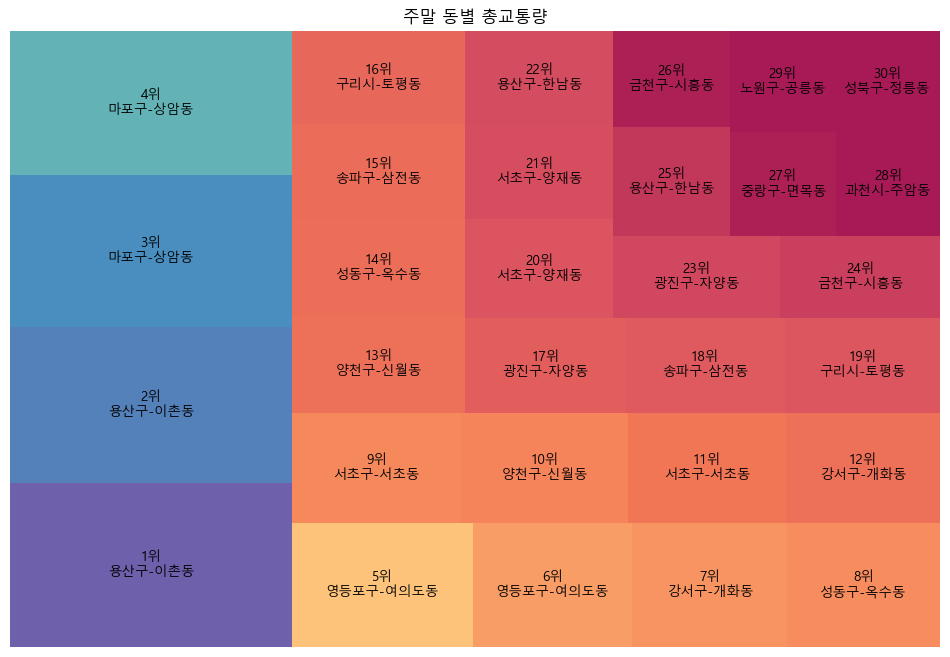

In [129]:
import squarify
import matplotlib.pyplot as plt
import numpy as np

top30 = region_summary.sort_values("총교통량", ascending=False).head(30).copy()
top30["rank"] = range(1, len(top30)+1)
top30["라벨"] = top30["rank"].astype(str) + "위\n" + top30["구"] + "-" + top30["동"]

# 컬러맵 바꾸기
norm_traffic = (top30["총교통량"] - top30["총교통량"].min()) / (top30["총교통량"].max() - top30["총교통량"].min())
colors = [plt.cm.Spectral(val) for val in norm_traffic]

plt.figure(figsize=(12,8))
squarify.plot(sizes=top30["총교통량"], label=top30["라벨"], 
              color=colors, alpha=0.9,  text_kwargs={'fontsize':9.7}) #pad=True,
plt.axis('off')
plt.title("주말 동별 총교통량")
plt.show()


In [126]:
region_summary

,지역,총교통량
1,남서부,18695464
0,남동부,17784352
3,북서부,14570587
2,북동부,13828643


C:\Users\s2arora\AppData\Local\Temp\ipykernel_31008\2426294538.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top30_sorted["라벨"], x=top30_sorted["총교통량"],


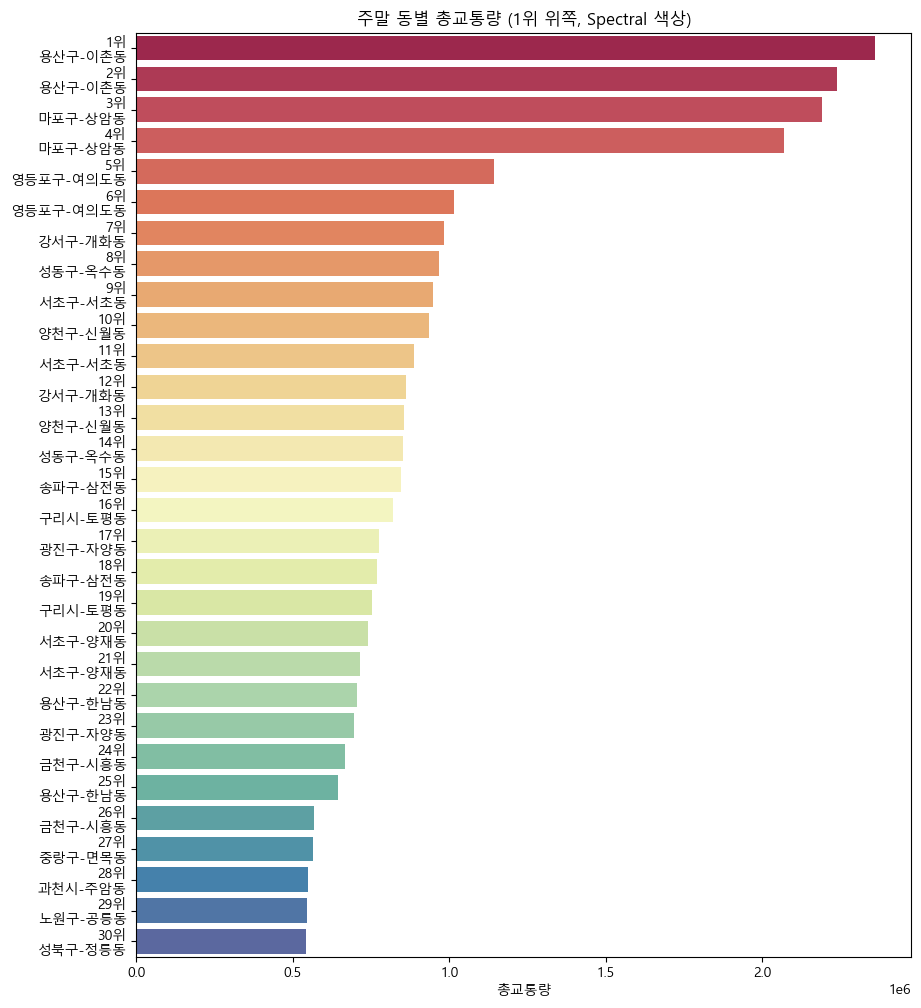

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# 순위 높은게 위로 오게
top30_sorted = top30.sort_values("rank")

plt.figure(figsize=(10,12))
sns.barplot(y=top30_sorted["라벨"], x=top30_sorted["총교통량"],
            palette=sns.color_palette("Spectral", n_colors=len(top30_sorted)))
plt.title("주말 동별 총교통량 (1위 위쪽, Spectral 색상)")
plt.xlabel("총교통량")
plt.ylabel("")
plt.show()


In [84]:
region_summary

,weekday,지역,구,총교통량
65,토요일,북동부,구리시,3767.0
44,토요일,남동부,과천시,3174.5
57,토요일,남서부,마포구,2603.0
49,토요일,남동부,용산구,2374.0
78,토요일,북서부,마포구,2341.0
...,...,...,...,...
41,일요일,북서부,중구,369.0
17,일요일,남서부,서초구,365.0
22,일요일,북동부,광진구,351.0
1,일요일,남동부,강동구,330.0


C:\Users\s2arora\AppData\Local\Temp\ipykernel_31008\946172442.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hourly_traffic, x="hour", y="총교통량", palette="viridis")


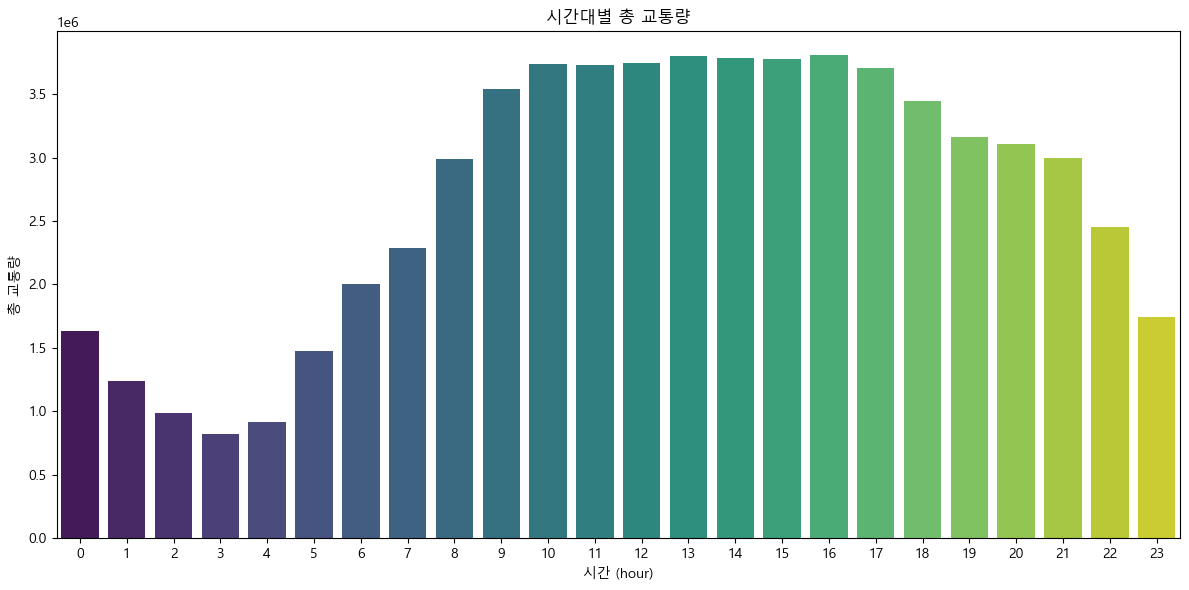

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시간별 총교통량 집계
hourly_traffic = df.groupby("hour")["총교통량"].sum().reset_index()

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_traffic, x="hour", y="총교통량", palette="viridis")
plt.title("시간대별 총 교통량")
plt.xlabel("시간 (hour)")
plt.ylabel("총 교통량")
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\s2arora\AppData\Local\Temp\ipykernel_59416\670680314.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=saturday_hourly, x="hour", y="총교통량", palette="Blues")
C:\Users\s2arora\AppData\Local\Temp\ipykernel_59416\670680314.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sunday_hourly, x="hour", y="총교통량", palette="Oranges")


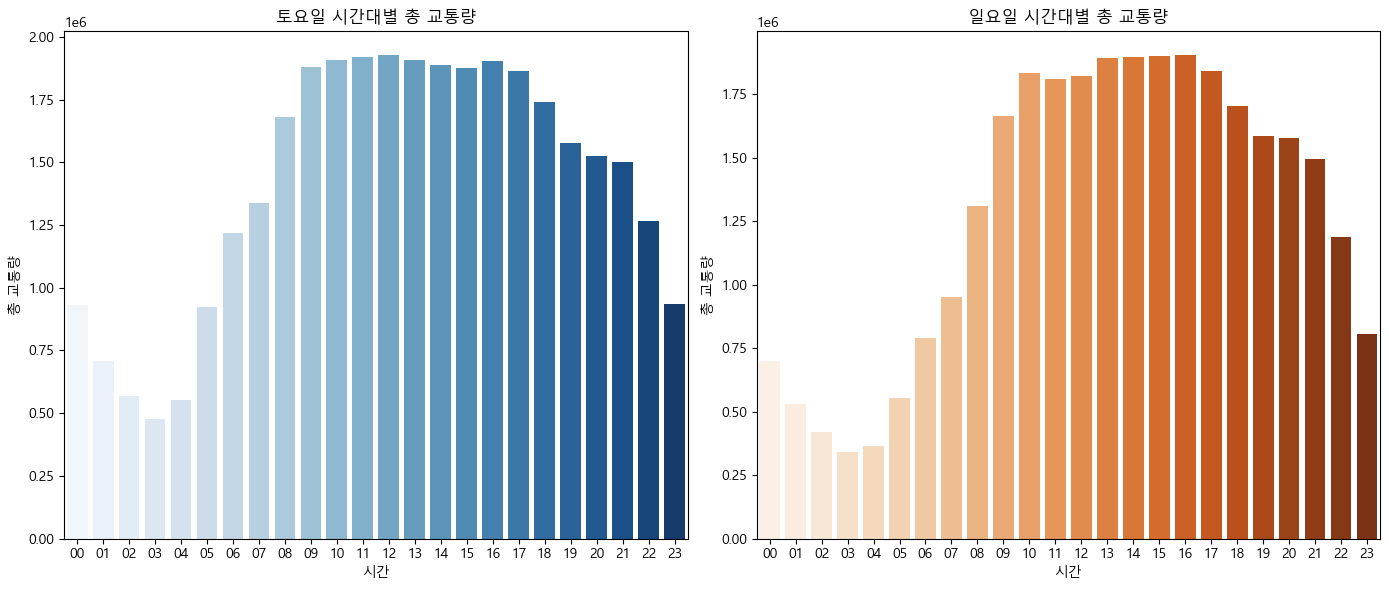

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 날짜 컬럼을 datetime으로 변환
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday"] = df["date"].dt.day_name()

# 토요일, 일요일 데이터 필터
saturday_df = df[df["weekday"] == "Saturday"]
sunday_df = df[df["weekday"] == "Sunday"]

# 시간별 총교통량 집계
saturday_hourly = saturday_df.groupby("hour")["총교통량"].sum().reset_index()
sunday_hourly = sunday_df.groupby("hour")["총교통량"].sum().reset_index()

# 시각화
plt.figure(figsize=(14, 6))

# 토요일 그래프
plt.subplot(1, 2, 1)
sns.barplot(data=saturday_hourly, x="hour", y="총교통량", palette="Blues")
plt.title("토요일 시간대별 총 교통량")
plt.xlabel("시간")
plt.ylabel("총 교통량")

# 일요일 그래프
plt.subplot(1, 2, 2)
sns.barplot(data=sunday_hourly, x="hour", y="총교통량", palette="Oranges")
plt.title("일요일 시간대별 총 교통량")
plt.xlabel("시간")
plt.ylabel("총 교통량")

plt.tight_layout()
plt.show()


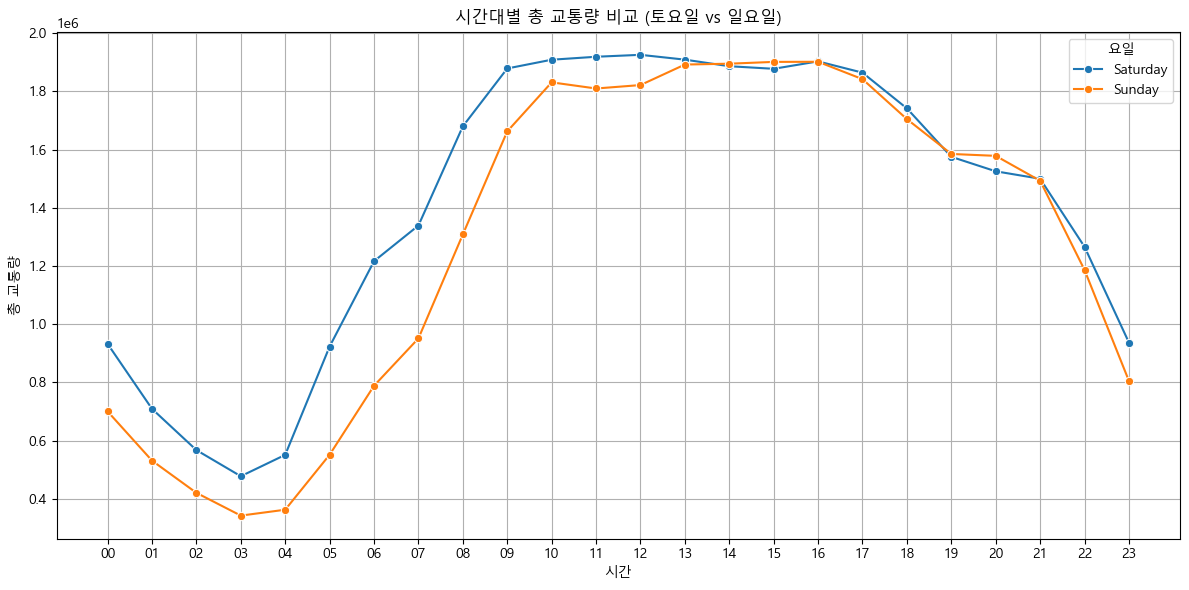

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 날짜 형식 변환 및 요일 추가
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday"] = df["date"].dt.day_name()

# 토요일/일요일 데이터 필터링
weekend_df = df[df["weekday"].isin(["Saturday", "Sunday"])]

# 시간대별, 요일별 교통량 집계
weekend_grouped = weekend_df.groupby(["weekday", "hour"])["총교통량"].sum().reset_index()

# 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekend_grouped, x="hour", y="총교통량", hue="weekday", marker='o')

plt.title("시간대별 총 교통량 비교 (토요일 vs 일요일)")
plt.xlabel("시간")
plt.ylabel("총 교통량")
plt.legend(title="요일")
plt.grid(True)
plt.tight_layout()
plt.show()


In [115]:
weekend_df

,date,hour,구,동,지역,spot_name,inout,총교통량,구분,weekday,weekday_eng
0,2025-04-05,0,강남구,삼성동,남동부,테헤란로(선릉역),1,942,유입,Saturday,Saturday
1,2025-04-05,0,강남구,삼성동,남동부,테헤란로(선릉역),2,1013,유출,Saturday,Saturday
2,2025-04-05,0,강남구,세곡동,남동부,밤고개로(세곡동사거리),1,177,유입,Saturday,Saturday
3,2025-04-05,0,강남구,세곡동,남동부,밤고개로(세곡동사거리),2,155,유출,Saturday,Saturday
4,2025-04-05,0,강남구,세곡동,남동부,헌릉로(세곡동사거리),1,330,유입,Saturday,Saturday
...,...,...,...,...,...,...,...,...,...,...,...
49479,2025-04-27,23,중구,순화동,북서부,세종대로(서울역),2,655,유출,Sunday,Sunday
49480,2025-04-27,23,중구,순화동,북서부,칠패로(숭례문),1,19,유입,Sunday,Sunday
49481,2025-04-27,23,중구,순화동,북서부,칠패로(숭례문),2,480,유출,Sunday,Sunday
49488,2025-04-27,23,중구,정동,북서부,서소문로(시청역),1,550,유입,Sunday,Sunday


C:\Users\s2arora\AppData\Local\Temp\ipykernel_59416\3147241673.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_sat, y="지역", x="총교통량", ax=axes[0], palette="Blues_d")
C:\Users\s2arora\AppData\Local\Temp\ipykernel_59416\3147241673.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_sun, y="지역", x="총교통량", ax=axes[1], palette="Oranges_d")


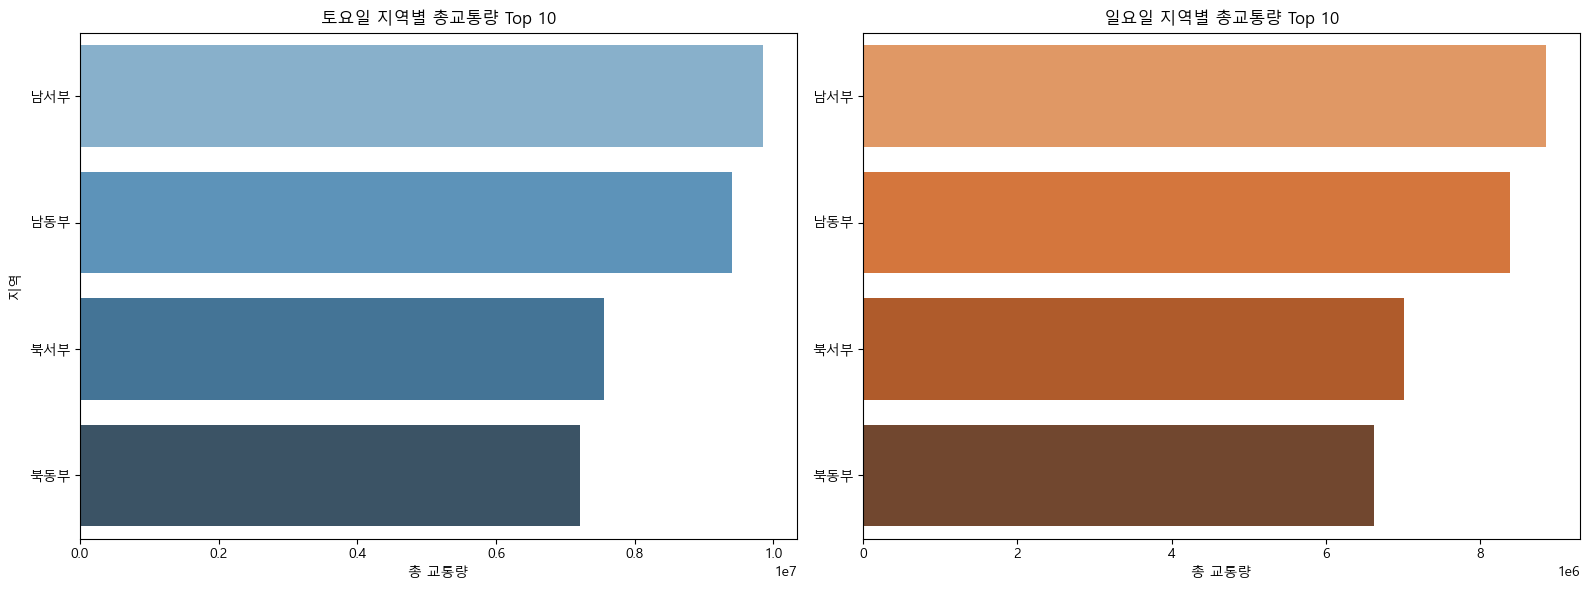

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 날짜형식과 요일 구하기
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday"] = df["date"].dt.day_name()

# 요일별 지역별 교통량 집계
weekend_df = df[df["weekday"].isin(["Saturday", "Sunday"])]
region_traffic = weekend_df.groupby(["weekday", "지역"])["총교통량"].sum().reset_index()

# 요일별 TOP10 지역 추출
top10_sat = region_traffic[region_traffic["weekday"] == "Saturday"].sort_values("총교통량", ascending=False).head(10)
top10_sun = region_traffic[region_traffic["weekday"] == "Sunday"].sort_values("총교통량", ascending=False).head(10)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=top10_sat, y="지역", x="총교통량", ax=axes[0], palette="Blues_d")
axes[0].set_title("토요일 지역별 총교통량 Top 10")
axes[0].set_xlabel("총 교통량")
axes[0].set_ylabel("지역")

sns.barplot(data=top10_sun, y="지역", x="총교통량", ax=axes[1], palette="Oranges_d")
axes[1].set_title("일요일 지역별 총교통량 Top 10")
axes[1].set_xlabel("총 교통량")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


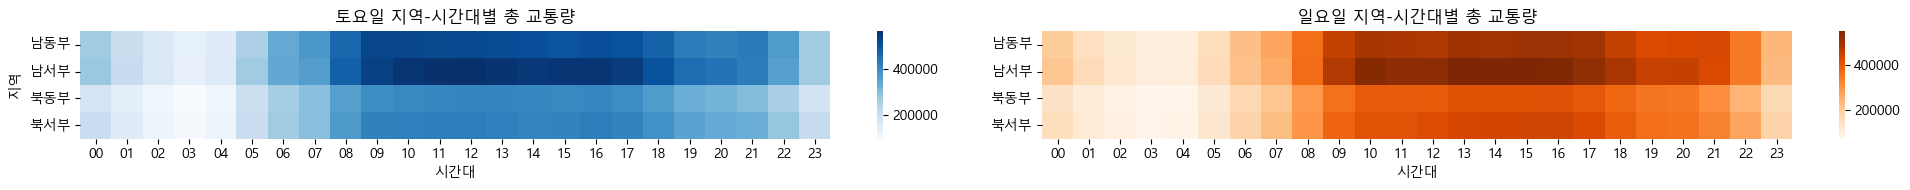

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 날짜를 datetime으로 변환하고 요일 추가
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday"] = df["date"].dt.day_name()

# 주말 데이터 필터링
weekend_df = df[df["weekday"].isin(["Saturday", "Sunday"])]

# 요일, 지역, 시간대별로 교통량 집계
grouped = weekend_df.groupby(["weekday", "지역", "hour"])["총교통량"].sum().reset_index()

# 🔵 토요일 피벗 테이블 생성 (행: 지역, 열: 시간대)
pivot_sat = grouped[grouped["weekday"] == "Saturday"].pivot(index="지역", columns="hour", values="총교통량").fillna(0)

# 🟠 일요일 피벗 테이블 생성
pivot_sun = grouped[grouped["weekday"] == "Sunday"].pivot(index="지역", columns="hour", values="총교통량").fillna(0)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(20, len(pivot_sat)//2))

sns.heatmap(pivot_sat, cmap="Blues", ax=axes[0])
axes[0].set_title("토요일 지역-시간대별 총 교통량")
axes[0].set_xlabel("시간대")
axes[0].set_ylabel("지역")

sns.heatmap(pivot_sun, cmap="Oranges", ax=axes[1])
axes[1].set_title("일요일 지역-시간대별 총 교통량")
axes[1].set_xlabel("시간대")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


In [29]:
import pandas as pd

# 올바른 CSV 파일을 업로드했다고 가정하고 불러오기
region_gb 

# 컬럼명이 없는 상태일 수 있으므로 열 개수 맞는지 확인 후 수동 지정
if region_gb.shape[1] == 11:
    region_gb.columns = ['date', 'hour', '구', '동', '지역', 'spot_name', 'inout', '총교통량', 'x', 'y', '구분']

# 날짜 처리 및 요일 파생
region_gb["date"] = pd.to_datetime(region_gb["date"], format="%Y%m%d", errors='coerce')
region_gb["weekday"] = region_gb["date"].dt.day_name()

# 주말만 필터링
weekend_df = region_gb[region_gb["weekday"].isin(["Saturday", "Sunday"])]

# 요약: 요일별, 구, 동, 지역별 총교통량 합계
weekend_summary = weekend_df.groupby(["weekday", "구", "동", "지역"])["총교통량"].sum().reset_index()

# 토요일, 일요일 분리
saturday_table = weekend_summary[weekend_summary["weekday"] == "Saturday"].drop(columns="weekday")
sunday_table = weekend_summary[weekend_summary["weekday"] == "Sunday"].drop(columns="weekday")

print("✅ 토요일 교통량 상위 10개")
print(saturday_table.sort_values("총교통량", ascending=False).head(10))

print("\n✅ 일요일 교통량 상위 10개")
print(sunday_table.sort_values("총교통량", ascending=False).head(10))


✅ 토요일 교통량 상위 10개
       구     동   지역     총교통량
69   용산구   이촌동  남서부  2359041
39   마포구   상암동  북서부  2191630
66  영등포구  여의도동  남서부  1143602
5    강서구   개화동  북서부   982728
53   성동구   옥수동  남동부   967434
48   서초구   서초동  남동부   948708
63   양천구   신월동  남서부   934305
60   송파구   삼전동  남동부   845740
27   구리시   토평동  북동부   818769
20   광진구   자양동  남동부   776104

✅ 일요일 교통량 상위 10개
        구     동   지역     총교통량
165   용산구   이촌동  남서부  2238993
135   마포구   상암동  북서부  2067992
162  영등포구  여의도동  남서부  1013859
144   서초구   서초동  남동부   888456
101   강서구   개화동  북서부   861013
159   양천구   신월동  남서부   855574
149   성동구   옥수동  남동부   850338
156   송파구   삼전동  남동부   768303
123   구리시   토평동  북동부   752700
145   서초구   양재동  남동부   714751


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 한글 폰트 설정
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# ✅ 데이터 불러오기
df_wk =region_gb
# ✅ 날짜 → datetime 변환, 요일 추가
df_wk["date"] = pd.to_datetime(df_wk["date"], format="%Y%m%d")
df_wk["요일"] = df_wk["date"].dt.day_name(locale="ko_KR")


In [12]:
# ✅ 요일별 direction별 볼륨 총합
요일별_최다 = (
    df_wk.groupby(["요일", "지역"])["총교통량"].sum().reset_index()
    .sort_values(["요일", "총교통량"], ascending=[True, False])
    .groupby("요일").head(1)
)

print("📌 주말 요일별 최다 혼잡 방향:")
print(요일별_최다)


📌 주말 요일별 최다 혼잡 방향:
    요일   지역     총교통량
1  일요일  남서부  8851271
5  토요일  남서부  9844193


In [17]:
# ✅ 요일별 direction별 볼륨 총합
요일별_최다 = (
    df_wk.groupby(["요일", "지역","구"])["총교통량"].sum().reset_index()
    .sort_values(["요일", "총교통량"], ascending=[True, False])
    .groupby("요일").head(1)
)

print("📌 주말 요일별 최다 혼잡 방향:")
print(요일별_최다)

📌 주말 요일별 최다 혼잡 방향:
     요일   지역    구     총교통량
20  일요일  남서부  용산구  2557064
62  토요일  남서부  용산구  2704970


In [16]:
# ✅ 요일별 direction별 볼륨 총합
요일별_최다 = (
    df_wk.groupby(["요일","지역", "구", "동" ])["총교통량"].sum().reset_index()
    .sort_values(["요일", "총교통량"], ascending=[True, False])
    .groupby("요일").head(1)
)

print("📌 주말 요일별 최다 혼잡 방향:")
print(요일별_최다)

📌 주말 요일별 최다 혼잡 방향:
      요일   지역    구    동     총교통량
46   일요일  남서부  용산구  이촌동  2238993
142  토요일  남서부  용산구  이촌동  2359041


In [18]:
# ✅ 시간별 direction별 볼륨 총합
시간별_최다 = (
    df_wk.groupby(["hour", "지역"])["총교통량"].sum().reset_index()
    .sort_values(["hour", "총교통량"], ascending=[True, False])
    .groupby("hour").head(1)
)

print("📌 주말 시간대별 최다 혼잡 방향:")
print(시간별_최다)


📌 주말 시간대별 최다 혼잡 방향:
   hour   지역     총교통량
1    00  남서부   484410
5    01  남서부   368500
9    02  남서부   290832
13   03  남서부   237922
17   04  남서부   262421
21   05  남서부   424503
24   06  남동부   562164
28   07  남동부   642628
33   08  남서부   843940
37   09  남서부  1008771
41   10  남서부  1089652
45   11  남서부  1088890
49   12  남서부  1094158
53   13  남서부  1104691
57   14  남서부  1099064
61   15  남서부  1101309
65   16  남서부  1102074
69   17  남서부  1063520
73   18  남서부   990897
77   19  남서부   906311
81   20  남서부   895749
84   21  남동부   864122
88   22  남동부   712632
92   23  남동부   502466


In [19]:
# ✅ 시간별 direction별 볼륨 총합
시간별_최다 = (
    df_wk.groupby(["hour", "지역",'구'])["총교통량"].sum().reset_index()
    .sort_values(["hour", "총교통량"], ascending=[True, False])
    .groupby("hour").head(1)
)

print("📌 주말 시간대별 최다 혼잡 방향:")
print(시간별_최다)


📌 주말 시간대별 최다 혼잡 방향:
    hour   지역    구    총교통량
20    00  남서부  용산구  156112
62    01  남서부  용산구  113934
104   02  남서부  용산구   91479
146   03  남서부  용산구   74734
188   04  남서부  용산구   86002
230   05  남서부  용산구  136549
256   06  남동부  서초구  181947
298   07  남동부  서초구  195446
356   08  남서부  용산구  254144
398   09  남서부  용산구  287091
440   10  남서부  용산구  287675
482   11  남서부  용산구  288616
524   12  남서부  용산구  285594
566   13  남서부  용산구  281070
608   14  남서부  용산구  276041
650   15  남서부  용산구  276057
692   16  남서부  용산구  278248
734   17  남서부  용산구  271849
776   18  남서부  용산구  261610
818   19  남서부  용산구  254738
860   20  남서부  용산구  262760
902   21  남서부  용산구  268976
944   22  남서부  용산구  230054
986   23  남서부  용산구  165383


In [20]:
# ✅ 시간별 direction별 볼륨 총합
시간별_최다 = (
    df_wk.groupby(["hour", "지역",'구','동'])["총교통량"].sum().reset_index()
    .sort_values(["hour", "총교통량"], ascending=[True, False])
    .groupby("hour").head(1)
)

print("📌 주말 시간대별 최다 혼잡 방향:")
print(시간별_최다)


📌 주말 시간대별 최다 혼잡 방향:
     hour   지역    구    동    총교통량
46     00  남서부  용산구  이촌동  135881
142    01  남서부  용산구  이촌동   99393
238    02  남서부  용산구  이촌동   79521
334    03  남서부  용산구  이촌동   65243
430    04  남서부  용산구  이촌동   76309
526    05  남서부  용산구  이촌동  122666
622    06  남서부  용산구  이촌동  160620
718    07  남서부  용산구  이촌동  171253
814    08  남서부  용산구  이촌동  222777
910    09  남서부  용산구  이촌동  248754
1006   10  남서부  용산구  이촌동  251122
1102   11  남서부  용산구  이촌동  250774
1198   12  남서부  용산구  이촌동  248575
1294   13  남서부  용산구  이촌동  243467
1390   14  남서부  용산구  이촌동  239437
1486   15  남서부  용산구  이촌동  240051
1582   16  남서부  용산구  이촌동  242675
1678   17  남서부  용산구  이촌동  238127
1774   18  남서부  용산구  이촌동  229261
1870   19  남서부  용산구  이촌동  222224
1966   20  남서부  용산구  이촌동  229006
2062   21  남서부  용산구  이촌동  234946
2158   22  남서부  용산구  이촌동  201663
2254   23  남서부  용산구  이촌동  144289


In [121]:
df

,date,hour,구,동,지역,spot_name,inout,총교통량,구분,weekday,weekday_eng
0,2025-04-05,0,강남구,삼성동,남동부,테헤란로(선릉역),1,942,유입,Saturday,Saturday
1,2025-04-05,0,강남구,삼성동,남동부,테헤란로(선릉역),2,1013,유출,Saturday,Saturday
2,2025-04-05,0,강남구,세곡동,남동부,밤고개로(세곡동사거리),1,177,유입,Saturday,Saturday
3,2025-04-05,0,강남구,세곡동,남동부,밤고개로(세곡동사거리),2,155,유출,Saturday,Saturday
4,2025-04-05,0,강남구,세곡동,남동부,헌릉로(세곡동사거리),1,330,유입,Saturday,Saturday
...,...,...,...,...,...,...,...,...,...,...,...
49479,2025-04-27,23,중구,순화동,북서부,세종대로(서울역),2,655,유출,Sunday,Sunday
49480,2025-04-27,23,중구,순화동,북서부,칠패로(숭례문),1,19,유입,Sunday,Sunday
49481,2025-04-27,23,중구,순화동,북서부,칠패로(숭례문),2,480,유출,Sunday,Sunday
49488,2025-04-27,23,중구,정동,북서부,서소문로(시청역),1,550,유입,Sunday,Sunday
